In [19]:
from neuralop.models import FNO
import torch
import pathlib

import acoustic_no
from importlib import reload

from acoustic_no.data import AcousticDataset
from acoustic_no.cno.cno_model import CNOModel 
#from acoustic_no.utils.eval import evaluate_model, plot_initial_conditions, plot_inference_results

reload(acoustic_no.utils.eval)
import acoustic_no.utils.eval as eval_utils



In [3]:
# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the dataset
dataset = AcousticDataset(
    data_dir=pathlib.Path("../resources/small_dataset/testing"),
    depth=64
)
print(f"Dataset size: {len(dataset)}")

depth = dataset.depth
print(f"Dataset depth: {depth}")


Using device: cuda
Dataset size: 8757
Dataset depth: 64


In [4]:
fno = FNO(
    n_modes=(16, 16),
    in_channels=depth * 3 + 1,
    out_channels=depth,
    n_layers=8,
    hidden_channels=128,
    projection_channel_ratio=2,
)
fno.load_state_dict(
    torch.load(
        "../resources/models/fno_baseline/best_model_state_dict.pt",
        map_location=device,
        weights_only=False
    )
)
fno.to(device)

tfno = FNO(
    n_modes=(16, 16),
    in_channels=depth * 3 + 1,
    out_channels=depth,
    n_layers=8,
    hidden_channels=128,
    projection_channel_ratio=2,
    factorization="Tucker"
)
tfno.load_state_dict(
    torch.load(
        "../resources/models/tfno/best_model_state_dict.pt",
        map_location=device,
        weights_only=False
    )
)
tfno.to(device)

cno = CNOModel(
    input_channels=depth * 3 + 1,
    hidden_channels=[128, 128, 256],
    layer_sizes=[3, 3, 4],
    output_channels=depth
)
cno.load_state_dict(
    torch.load(
        "../resources/models/cno/best_model.pth",
        map_location=device
    )
)
cno.to(device)

pass


In [6]:
models = {
    "FNO": fno,
    "TFNO": tfno,
    "CNO": cno
}

results = eval_utils.evaluate_models(models, dataset, device)


Evaluating: 100%|██████████| 8757/8757 [04:31<00:00, 32.30sample/s]

----------------------------------------
Average results for model 'FNO':
  MSE:         13.932867
  L2 Loss:     49.230886
  H1 Loss:     51.069296
  Relative L2: 0.807822
  Max Error:   50.923358
----------------------------------------
Average results for model 'TFNO':
  MSE:         18.452117
  L2 Loss:     52.055132
  H1 Loss:     54.566852
  Relative L2: 0.852592
  Max Error:   52.425806
----------------------------------------
Average results for model 'CNO':
  MSE:         1.980019
  L2 Loss:     20.405886
  H1 Loss:     21.855785
  Relative L2: 0.335611
  Max Error:   41.188366


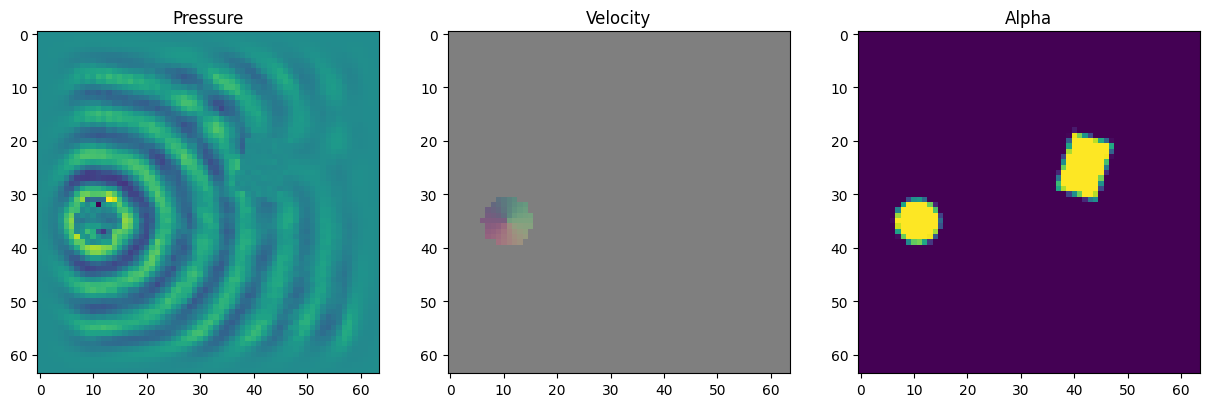

In [5]:
eval_utils.plot_initial_conditions(dataset)



Running inference on model (CNO)...
Plotting error evolution...
Plotting error distribution...


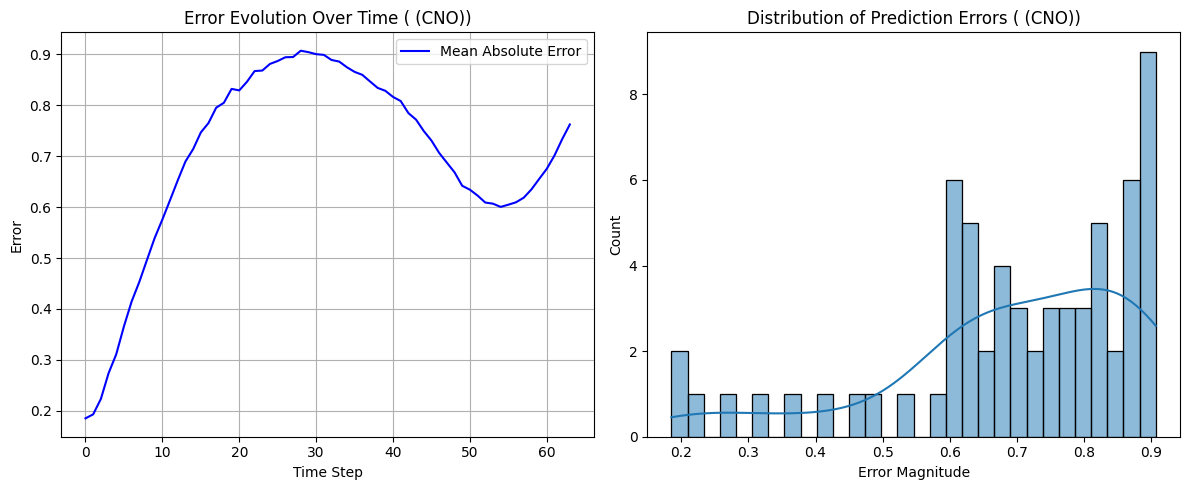

Error plots saved.


In [6]:
eval_utils.plot_inference_results(cno, dataset,
                                  path=None, kind="error", name="CNO")


Sampled 8757 initial conditions.


Evaluating: 100%|██████████| 8757/8757 [00:03<00:00, 2402.27sample/s]


----------------------------------------
Average results for model 'CNO (iterative)':
  MSE:       10.404075
  L2 Loss:   0.783906
  H1 Loss:   0.815616
  Max Error: 47.042977
Plotting error evolution...
Plotting error distribution...


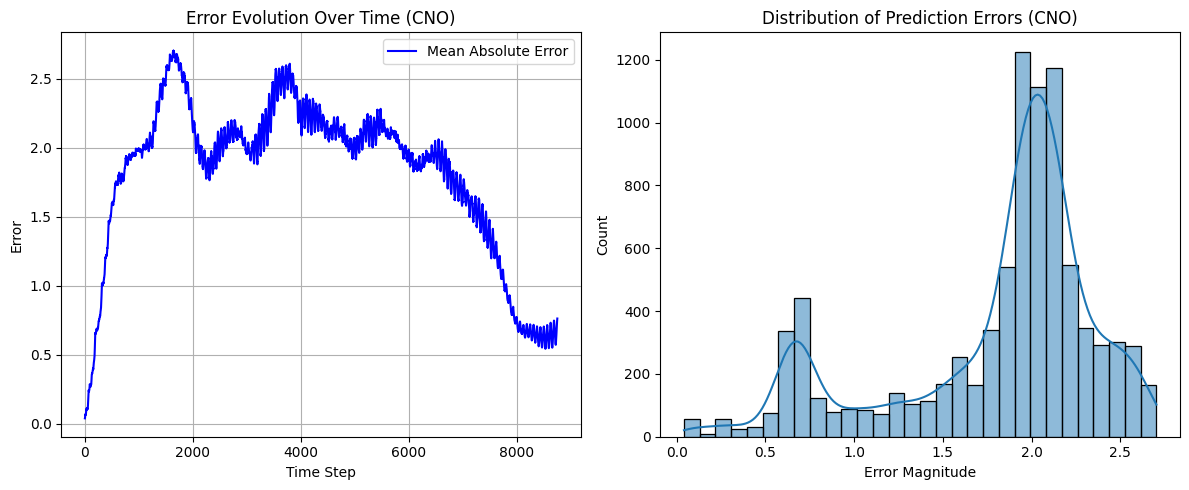

Error plots saved.


In [22]:
# Plot pressure for middle sample (generated iteratively)
#eval_utils.sample_iterative(cno, dataset, device, kind="pressure", name="CNO")

# Warning: It will probably take >30 minutes to generate a full animation
#eval_utils.sample_iterative(cno, dataset, device, kind="animation", name="CNO")

# Plot error evolution/distribution for entire dataset (generated iteratively)
eval_utils.sample_iterative(cno, dataset, device, kind="error", name="CNO", compute_metrics=True)

# Plot error evolution/distribution for middle sample (generated iteratively)
#eval_utils.sample_iterative(cno, dataset, device, kind="error", name="CNO", index=len(dataset) // 2)


# Testing (ignore)

In [ ]:
model = fno  # Change this to fno, tfno, or cno to evaluate models
model.to(device)
model.eval()

y_true = []
y_pred = []
i = 0
init_cond = dataset[0]["x"][0, :, :].detach().cpu()

while i < len(dataset):
    data = dataset[i]
    x = data["x"].detach().clone()
    p = data["y"]
    x[0, :, :] = init_cond
    with torch.no_grad():
        pred = model(x.unsqueeze(0).to(device)).squeeze()
    init_cond = pred[-1, :, :].detach().cpu()

    y_true.append(p[:-1].cpu())
    y_pred.append(pred[:-1].cpu())

    i += dataset.depth - 1  # Skip to the next initial condition
y_true = torch.stack(y_true).flatten(0, 1)[:len(dataset)]
y_pred = torch.stack(y_pred).flatten(0, 1)[:len(dataset)]

y_true.shape, y_pred.shape


(torch.Size([8757, 64, 64]), torch.Size([8757, 64, 64]))

In [ ]:
p.shape, pred.shape


(torch.Size([64, 64, 64]), torch.Size([64, 64, 64]))

In [ ]:
torch.linalg.norm(x[0] - p[0])
x.shape


torch.Size([193, 64, 64])